In [9]:
import numpy as np
import pandas as pd
from alibi_detect.od import IForest  # Import the outlier detection algorithm of choice
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Configuration 

In [10]:
DATA_SET = 'physionet' # can be {'bodo', 'physionet'}
MIN_LENGTH_OF_STAY = 40
MAX_LENGTH_OF_STAY = 120
SAMPLES_TO_PREDICT = 8
WARD_TO_USE = 'WardALL'
# STATIC_VARIS = []
STATIC_VARIS = ['Age', 'Gender', 'Weight']

WEIGHTS_PATH = './weights/'
DATA_PATH = './data/'
PATH_IMAGES = './images/'
PATH_ENCODED_DATA = './output/'

WEIGHTS_NAME = f'weight_{DATA_SET}_O{MIN_LENGTH_OF_STAY}U{MAX_LENGTH_OF_STAY}_{WARD_TO_USE}_SV{STATIC_VARIS}_pred{SAMPLES_TO_PREDICT}.h5'
DATA_NAME = f'triplets_{DATA_SET}_O{MIN_LENGTH_OF_STAY}U{MAX_LENGTH_OF_STAY}_{WARD_TO_USE}.pkl'
if DATA_SET == 'bodo':
    DATA_ORIGNIAL = f'EWS_0122-0423_scrubbed_O{MIN_LENGTH_OF_STAY}U{MAX_LENGTH_OF_STAY}.csv'
elif DATA_SET == 'physionet':
    DATA_ORIGNIAL = 'physionet_2012_preprocessed_noNormalization.pkl'
ENCODED_DATA = f'{WEIGHTS_NAME[0:-3]}_{DATA_NAME[0:-4]}.pkl'

SAVE_HIST_COMPARE = True
IFOREST_THRESHOLD = 99
IFOREST_ESTIMATORS = 3000

# Load encoded and original data

In [11]:
df_encoded = pickle.load(open(PATH_ENCODED_DATA+ENCODED_DATA, 'rb'))

df_patient_meta = pd.DataFrame(df_encoded.PatientID)
encodded_data = df_encoded.drop('PatientID',axis=1)
encodded_data.columns = encodded_data.columns.astype(str)

if DATA_SET == 'bodo':
    df_orig = pd.read_csv(DATA_PATH+DATA_ORIGNIAL)
elif DATA_SET == 'physionet':
    df_orig, _ , _, _, _ = pickle.load(open(DATA_PATH+'physionet_2012_preprocessed_noNormalization.pkl', 'rb'))
    # pd.read_csv(DATA_PATH+'physionet_2012_preprocessed_noNormalization.pkl', 'rb')#DATA_PATH+DATA_ORIGNIAL)

len(df_orig.ts_ind.unique()), len(encodded_data)



(7990, 7729)

# Normalize original data

In [12]:
if DATA_SET == 'bodo':
    df_orig['onO2'] = 0
    df_orig.loc[df_orig.AirOrO2 == 'Oksygen', 'onO2'] = 1
    del df_orig["AirOrO2"] 

    df_orig['Unconscious'] = 0
    df_orig.loc[df_orig.Consciousness != 'Våken', 'Unconscious'] = 1
    del df_orig["Consciousness"] 

    del df_orig['Index']
    df_orig = df_orig.reindex(columns=[
    'PatientID','WardID','Timestamp','Systolic','Diastolic','O2','Pulse','Temp','Rf','Gender','onO2','EwsScore','EwsType','Unconscious','WardName'])
    df_orig.loc[df_orig.Gender == 'M', 'Gender'] = 1
    df_orig.loc[df_orig.Gender == 'F', 'Gender'] = 0
    df_orig.loc[df_orig.Gender == 'U', 'Gender'] = -1
    df_orig.loc[df_orig.Gender == 'None', 'Gender'] = -1


    # Use all wards or only a single WardID  # alternatives {'Ward2','Ward3','WardALL','WardNO'}
    if WARD_TO_USE == 'ALLWard':
        df_orig_ward_choosen = df_orig
    elif WARD_TO_USE == 'Ward2':
        df_orig_ward_choosen = df_orig[df_orig.WardID == 2]
    elif WARD_TO_USE == 'Ward3':
        df_orig_ward_choosen = df_orig[df_orig.WardID == 3]
    elif WARD_TO_USE == 'WardNO':
        df_orig_ward_choosen = df_orig.drop('WardID', axis=1)

    # normalize for optimal value
        #opt_val = [['PatientID','WardID','Timestamp', 'Systolic', 'Diastolic', 'O2', 'Pulse', 'Temp', 'Rf', 'Gender', 'onO2',   'Unconscious', 'WardName']]
    # if WARD_TO_USE == 'WardNO':
    #     opt_val = [     0,                      0,          120,        80,      96,    70,     37,     16,     0,        0,             0,       0   ]
    # else:
    opt_val = [     0,          0,          0,          120,        80,      96,    70,     37,     16,     0,        0,             0,       0   ]

    df_optDist = df_orig.iloc[:,:-2] - opt_val
    df_optDist['Unconscious'] = df_orig['Unconscious']
    df_optDist['WardName'] = df_orig['WardName']

    df_optDist.sort_values(by=['PatientID','Timestamp'], inplace=True,
                ascending = [True,True])
    # df.index = range(1,len(df)+1)
    if WARD_TO_USE == 'WardNO':    df_optDist = df_optDist[['PatientID','Timestamp', 'Systolic', 'Diastolic', 'O2', 'Pulse', 'Temp', 'Rf', 'Gender','onO2' ,'Unconscious']]
    else:    df_optDist = df_optDist[['PatientID','Timestamp','WardID', 'Systolic', 'Diastolic', 'O2', 'Pulse', 'Temp', 'Rf', 'Gender','onO2' ,'Unconscious']]


    # df_orig_ohehot = pd.get_dummies(df_orig, prefix='Unconscious')


    # Normalize continious features
    means = df_optDist.mean(axis=0)
    stds = df_optDist.std(axis=0)
    if WARD_TO_USE == 'WardNO':
        means[['PatientID','Timestamp','onO2' ,'Unconscious']] = 0,0,0,0
        stds[['PatientID','Timestamp','onO2' ,'Unconscious']] = 1,1,1,1
    else:
        means[['PatientID','Timestamp','WardID','onO2' ,'Unconscious']] = 0,0,0,0,0
        stds[['PatientID','Timestamp','WardID','onO2' ,'Unconscious']] = 1,1,1,1,1
    df_mean = (df_optDist-means)/stds

    df_mean = df_mean.groupby('PatientID').mean().reset_index()
    df_mean = df_mean.drop('Timestamp', axis=1)
    df_mean

# Outlier detection

In [13]:
encodded_data

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-0.611185,1.233248,-0.878414,0.358452,0.090477,1.131894,1.409113,-0.781281,0.770955,-0.017890,...,0.679719,1.284865,0.863454,-0.594984,-0.836894,0.384021,-0.010078,-0.178217,0.017211,0.508126
1,0.026909,2.021533,-1.593565,-0.099176,0.109389,0.837771,1.468913,-0.844213,1.288151,0.585016,...,0.632616,1.090790,1.617875,-0.712224,-1.238702,0.819032,-0.280985,-0.404148,-0.076994,0.199944
2,-0.121517,1.929940,-1.516151,-0.020020,0.058937,0.939887,1.554084,-0.867801,1.185785,0.450673,...,0.619987,1.179299,1.532522,-0.711186,-1.202372,0.811420,-0.266143,-0.341841,-0.073033,0.311976
3,-0.288353,1.458885,-1.144070,0.154057,0.150767,0.815195,1.468328,-0.879527,0.849181,0.173282,...,0.564472,1.227472,1.170578,-0.592247,-0.987870,0.523346,-0.158068,-0.211044,-0.014966,0.438836
4,-0.683254,1.297582,-0.895459,0.375996,0.032818,1.277258,1.492125,-0.773153,0.813509,-0.058597,...,0.708806,1.379883,0.882097,-0.638931,-0.844390,0.445209,-0.018857,-0.185233,-0.004913,0.551901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7724,-0.148296,2.020562,-1.527026,0.003705,0.047565,1.033813,1.519489,-0.828692,1.212161,0.503425,...,0.656117,1.171386,1.550510,-0.716549,-1.240030,0.849512,-0.246474,-0.368526,-0.082387,0.258567
7725,-0.009695,2.045483,-1.588610,-0.070509,0.116037,0.872018,1.475031,-0.840447,1.237116,0.588892,...,0.636598,1.081510,1.595925,-0.705058,-1.223431,0.862881,-0.285414,-0.420586,-0.076235,0.194602
7726,-0.210872,1.847487,-1.453435,0.058078,0.080740,0.956013,1.574194,-0.879352,1.101324,0.371264,...,0.600415,1.239416,1.461933,-0.682139,-1.153115,0.781837,-0.224625,-0.316377,-0.059099,0.363297
7727,-0.256951,1.697700,-1.358358,0.166606,0.153425,0.965535,1.522433,-0.912242,0.989372,0.319015,...,0.632686,1.251997,1.362297,-0.648410,-1.117596,0.697251,-0.176075,-0.343221,-0.083796,0.406146


We found 78 outliers and 7651 non outliers.


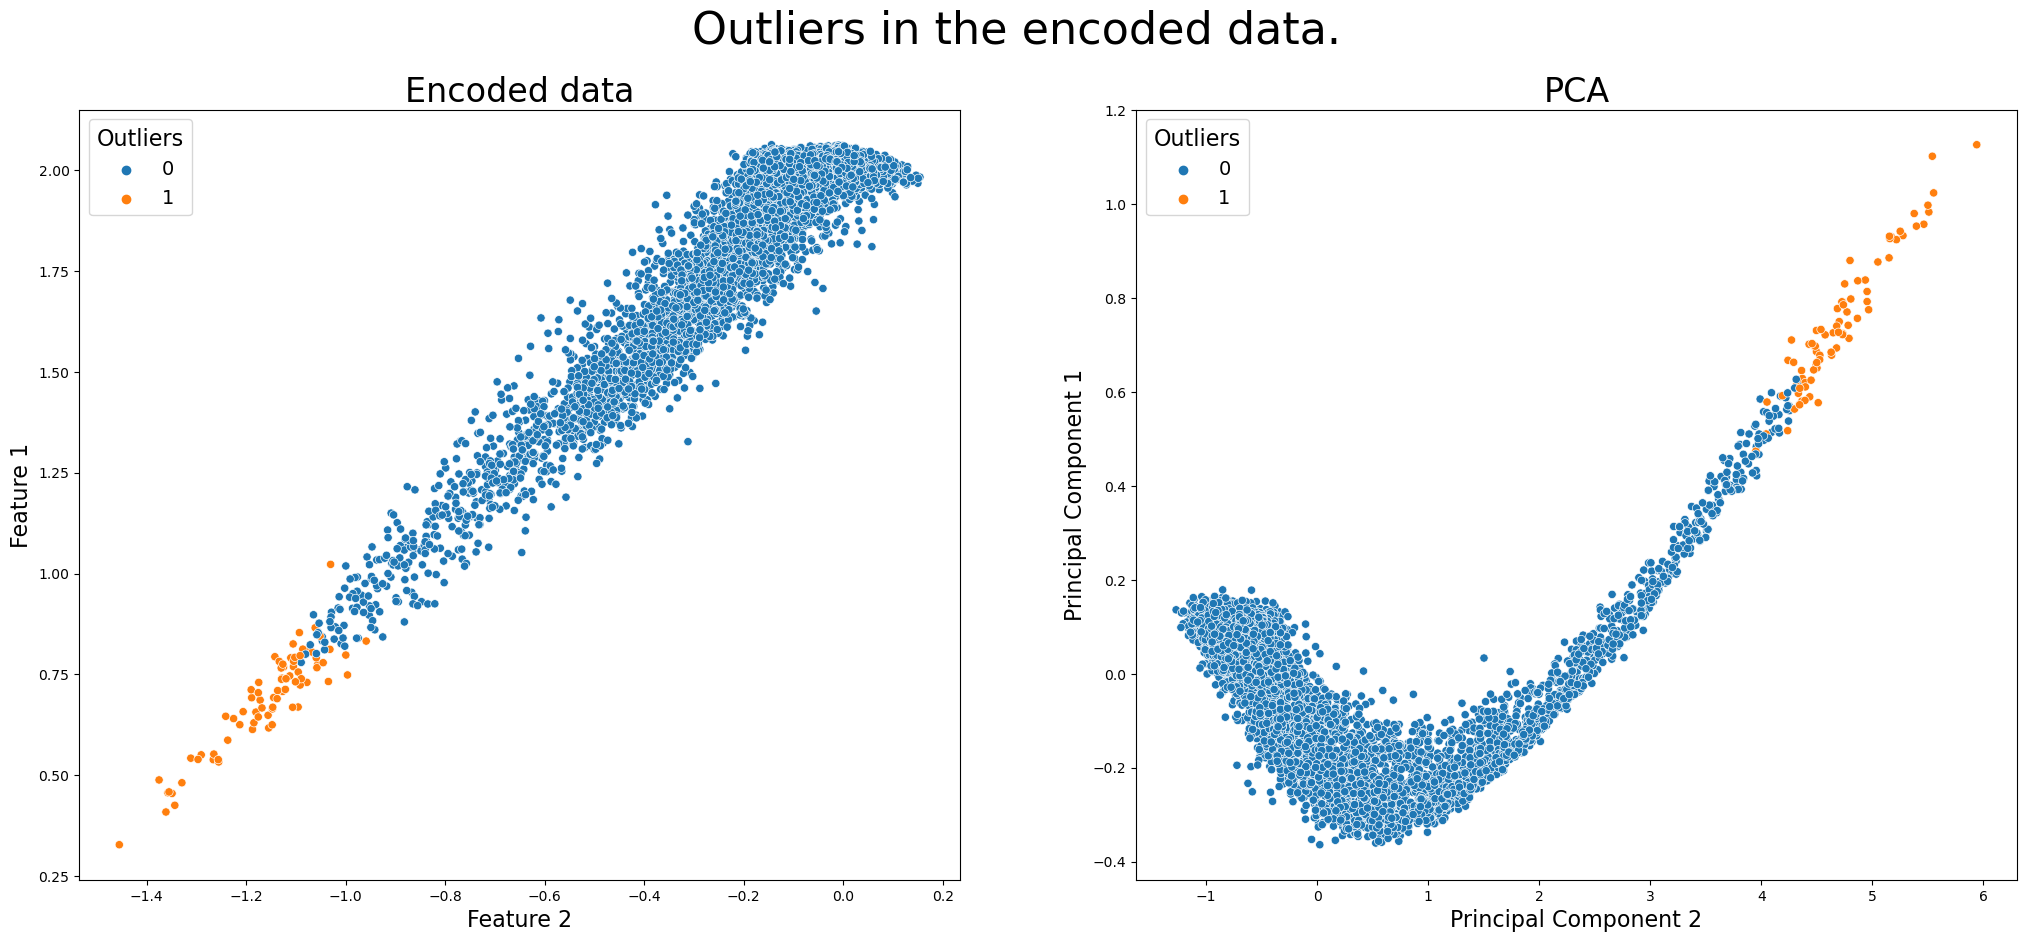

In [14]:
def plot_compare_outliers(data1, data2, hue, title='title', subtitle_first='subtitle_first', subtitle_second='subtitle_second'):
    # Plot outliers and data
    x_axis1 = data1.columns[0]
    y_axis1 = data1.columns[1]
    x_axis2 = data2.columns[0]
    y_axis2 = data2.columns[1]
    fig, ax = plt.subplots(1,2, figsize=(25,10))
    plt.suptitle(title, fontsize=32)

    sns.scatterplot(data = data1, x = x_axis1, y = y_axis1, hue=hue, alpha=1, legend=True, ax=ax[0])
    ax[0].set_ylabel('Feature 1', fontsize=16)
    ax[0].set_xlabel('Feature 2', fontsize=16)
    ax[0].set_title(subtitle_first, fontsize=24)
    legend = ax[0].legend(fontsize=14) 
    legend.set_title("Outliers", prop={"size": 16})

    sns.scatterplot(data = data2, x = x_axis2, y = y_axis2, hue=hue, alpha=1, legend=True, ax=ax[1])
    ax[1].set_ylabel('Principal Component 1', fontsize=16)
    ax[1].set_xlabel('Principal Component 2', fontsize=16)
    ax[1].set_title(subtitle_second, fontsize=24)
    legend = ax[1].legend(fontsize=14) 
    legend.set_title("Outliers", prop={"size": 16})
    return fig, ax 

def Iforest_outliers(encodded_data, threshold=95, estimators=1000):
    detector = IForest(threshold=0, n_estimators=estimators)
    detector.fit(encodded_data)
    anomaly_scores = detector.score(encodded_data)
    threshold = np.percentile(anomaly_scores, threshold)
    detector_with_threshold = IForest(threshold=threshold, n_estimators=estimators)
    detector_with_threshold.fit(encodded_data)
    preds = detector_with_threshold.predict(encodded_data)
    return preds


np.random.seed(42)
preds = Iforest_outliers(encodded_data, threshold=IFOREST_THRESHOLD, estimators=IFOREST_ESTIMATORS)
# Add the outlier predictions back to the DataFrame
df_patient_meta['is_outlier'] = preds['data']['is_outlier']
df_patient_meta['instance_score'] = preds['data']['instance_score']

# Print the DataFrame with the outlier predictions
unique_outliers = np.unique(df_patient_meta.is_outlier, return_counts=True)
try: print(f'We found {unique_outliers[1][1]} outliers and {unique_outliers[1][0]} non outliers.')
except: print('We found no outliers')

outliers = df_patient_meta[df_patient_meta.is_outlier == 1]

pca = PCA(n_components=8) # create a PCA object
df_pca_val = encodded_data.values
pca.fit(df_pca_val)
pca_data = pca.transform(df_pca_val)
cols = ['PC' + str(x) for x in range(1, pca_data.shape[1]+1)]
pca_df = pd.DataFrame(pca_data, columns=cols)

# look at outliers in original Data
# df_orig_outliers = df_orig[df_orig.PatientID.isin(outliers.PatientID)]


# plot outliers
fig, ax = plot_compare_outliers(encodded_data, pca_df, hue=df_patient_meta.is_outlier, title= "Outliers in the encoded data.", subtitle_first =  'Encoded data', subtitle_second = 'PCA')

plt.savefig(f'{PATH_IMAGES}Outliers_{WEIGHTS_NAME[0:-3]}_{DATA_NAME[0:-4]}.png', dpi=300)


# Trying to figur out if there is a common thing for the outliers. 

In [15]:
def hist_compare(outlier_param, orig_param, title='Title', opt_val=0, save_fig=False):
    # get the same bins for both histograms.
    min_val = min(outlier_param.min(), orig_param.min())
    max_val = max(outlier_param.max(), orig_param.max())
    num_bins = 20
    bin_width = (max_val - min_val) / num_bins
    bins = np.arange(min_val, max_val + bin_width + 0.00001, bin_width)

    plt.hist(outlier_param, bins=bins, color='blue', alpha=0.5, label='Outlier', density=True)
    plt.hist(orig_param, bins=bins, color='red', alpha=0.5, label='Original', density=True)
    plt.title(title, fontsize=24)
    plt.xlabel('Value')
    plt.ylabel('Density')
    if opt_val != 0:
        plt.axvline(x=opt_val, color='darkgreen', linestyle='--', label='Optimal value')

    plt.legend()
    plt.show()
    if save_fig:
        plt.savefig(f'{PATH_IMAGES}featur_comparison_hist/{WEIGHTS_NAME[0:-3]}_{param}.png', dpi=300)


# Group outliers and original data. 
groups_outlier = df_orig[df_orig.PatientID.isin(df_orig_outliers.PatientID)].groupby('PatientID')
groups_orig = df_orig.groupby('PatientID')
# plot histograms of parameters to compare distribution of outliers and original data.
samplefrequency_outlier = (groups_outlier.Timestamp.max() - groups_outlier.Timestamp.min()) / 3600000 / groups_outlier.size()
samplefrequency_orig = (groups_orig.Timestamp.max() - groups_orig.Timestamp.min()) / 3600000 / groups_orig.size()

hist_compare(samplefrequency_outlier, samplefrequency_orig, title='Sample frequency')


#opt_val = [['PatientID','WardID','Timestamp', 'Systolic', 'Diastolic', 'O2', 'Pulse', 'Temp', 'Rf', 'Gender', 'onO2',  'EwsScore' 'EwsType' 'Unconscious', 'WardName']]
opt_val_plot = [     0,     0,          0,          120,        80,      96,    70,     37,     16,     0,        0,         0,        0,          0,          0   ]
for i, param in enumerate(groups_orig.head(0)):
    if i in [0,14]:
        continue
    param = str(param)
    hist=hist_compare(groups_outlier[param].mean(), groups_orig[param].mean(),title=f'{param} mean', opt_val=opt_val_plot[i], save_fig=SAVE_HIST_COMPARE)


AttributeError: 'DataFrame' object has no attribute 'PatientID'

# Compare to non encoded data

C:\Users\burma\AppData\Local\Temp\ipykernel_12400\1839819769.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_mean = df_orig.groupby('PatientID').mean().reset_index()


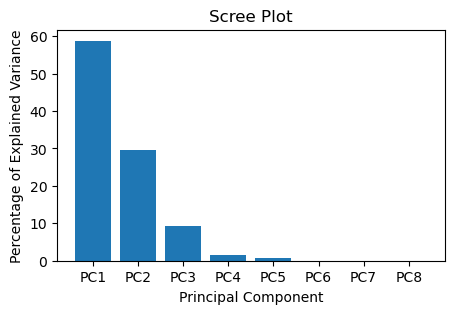

In [ ]:
# Calculate the mean value for each column using groupby
df_mean = df_orig.groupby('PatientID').mean().reset_index()

pca = PCA(n_components=8) # create a PCA object
df_orig_pca_val = df_mean[['Systolic', 'Diastolic', 'O2', 'Pulse', 'Temp', 'Rf','onO2' ,'Unconscious']].values
pca.fit(df_orig_pca_val)
pca_data_prig = pca.transform(df_orig_pca_val)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
cols = ['PC' + str(x) for x in range(1, len(per_var)+1)]

pca_df_orig = pd.DataFrame(pca_data_prig, columns=cols)


plt.figure(figsize=(5,3)) 
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=cols)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')

plt.show()

In [ ]:
len(df_orig.PatientID.unique()),len(pca_df_orig), len(pca_df_orig), len(preds['data']['is_outlier']), len(df_patient_meta)

(17037, 17037, 17037, 17037, 17037)

We found 158 outliers and 16879 non outliers.


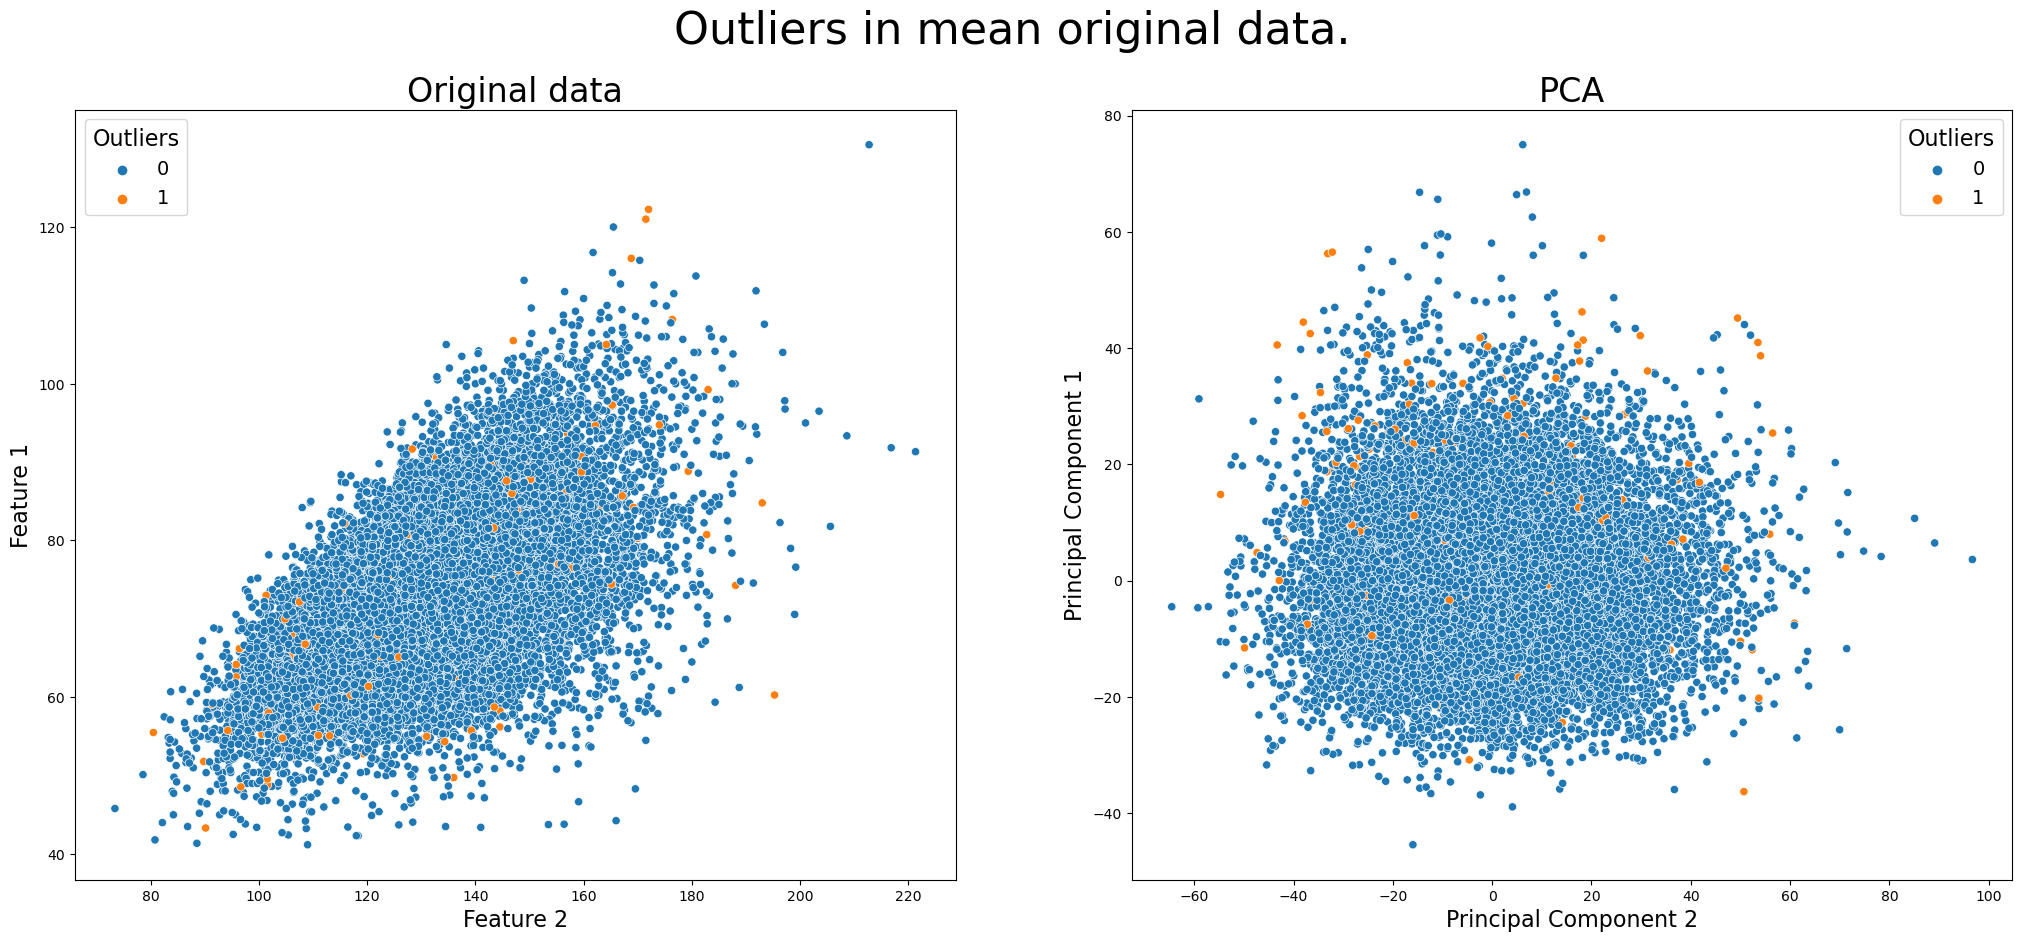

In [ ]:
data = df_mean[['Systolic', 'Diastolic', 'O2', 'Pulse', 'Temp', 'Rf','onO2' ,'Unconscious']]

np.random.seed(42)
preds = Iforest_outliers(pca_df_orig, threshold=IFOREST_THRESHOLD, estimators=IFOREST_ESTIMATORS)

# Add the outlier predictions back to the DataFrame
df_patient_meta['is_outlier'] = preds['data']['is_outlier']
df_patient_meta['instance_score'] = preds['data']['instance_score']

# Print the DataFrame with the outlier predictions
unique_outliers = np.unique(df_patient_meta.is_outlier, return_counts=True)
try: print(f'We found {unique_outliers[1][1]} outliers and {unique_outliers[1][0]} non outliers.')
except: print('We found no outliers')

outliers = df_patient_meta[df_patient_meta.is_outlier == 1]

# look at outliers in original Data
df_orig_outliers_noEnc = df_orig[df_orig.PatientID.isin(outliers.PatientID)]


# plot outliers
fig, ax = plot_compare_outliers(data, pca_df_orig, hue=df_patient_meta.is_outlier, title= "Outliers in mean original data.", subtitle_first =  'Original data', subtitle_second = 'PCA')
plt.savefig(f'{PATH_IMAGES}Original_data_Outliers_{WEIGHTS_NAME[0:-3]}_{DATA_NAME[0:-4]}.png', dpi=300)
